In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
%cd /content/drive/MyDrive



/content/drive/MyDrive


In [83]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
%matplotlib inline

sklearn for KMeans algorithm, matplotlib.pyplot for plotting graphs, numpy to work with arrays, cv2 to work with image data, collections to use Counter to count values, rgb2lab to convert RGB values and deltaE_cie76 to calculate similarity between colors.


In [43]:
%cd /content/drive/MyDrive/Colab Notebooks/samples

/content/drive/MyDrive/Colab Notebooks/samples


In [84]:
image = cv2.imread('image_1.jpg')
print("The type of this input is {}".format(type(image)))

The type of this input is <class 'numpy.ndarray'>


Shape: (426, 640, 3)


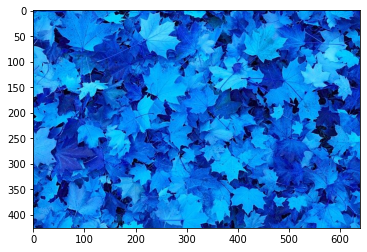

In [85]:
print("Shape: {}".format(image.shape))
plt.imshow(image)

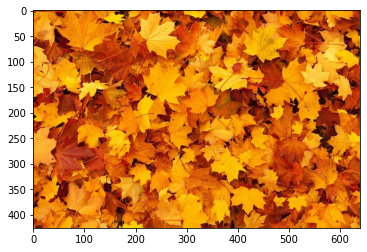

In [86]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

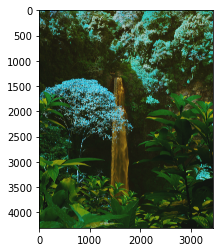

In [87]:
image2 = cv2.imread("image_2.jpg")
plt.imshow(image2)


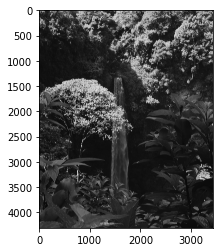

In [88]:
gray_image = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

This mage converted to grayscale if needed.

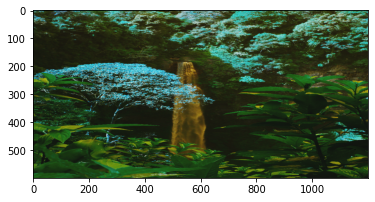

In [89]:
resized_image = cv2.resize(image2, (1200, 600))
plt.imshow(resized_image)

resize the image to a certain size whenever the images are huge

In [90]:
#define a function that can give us the hex values of our the colors that we will identify.


def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


In [91]:

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [92]:
"""KMeans expects flattened array as input during its fit method.
 Thus,  need to reshape the image using numpy. 
 Then apply KMeans to first fit and then predict on the image to get the results. Then, the cluster colors are identified an arranged in the correct order. 
  plot the colors as a pie chart."""
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

[array([ 34.67145948, 123.18232219,  63.61074552]),
 array([25.57985528, 56.5496575 , 38.86782441]),
 array([151.23389495, 192.93673604, 127.74479683]),
 array([19.71191524, 29.996283  , 26.30096109]),
 array([24.69686643, 90.40856207, 43.21149597]),
 array([ 52.33750636, 138.79694656, 121.80366412]),
 array([32.29803723, 75.72303904, 80.71166799]),
 array([ 97.28589889, 167.43870134,  89.51905993])]

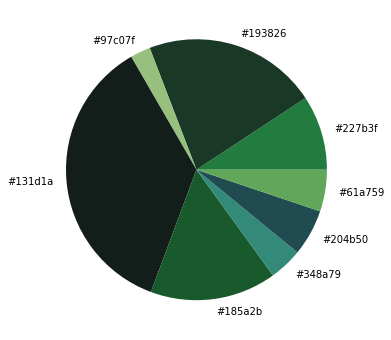

In [93]:
get_colors(get_image('image_4.jpg'), 8, True)

In [94]:
"""From the model above, extract the major colors. 
This create the opportunity to search for images based on certain colors. 
select a color and 
if it's hex matches or is close to the hex of the major colors of the image,
  say it's a match"""
IMAGE_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/samples'
COLORS = {
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0]
}
images = []


In [95]:
for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

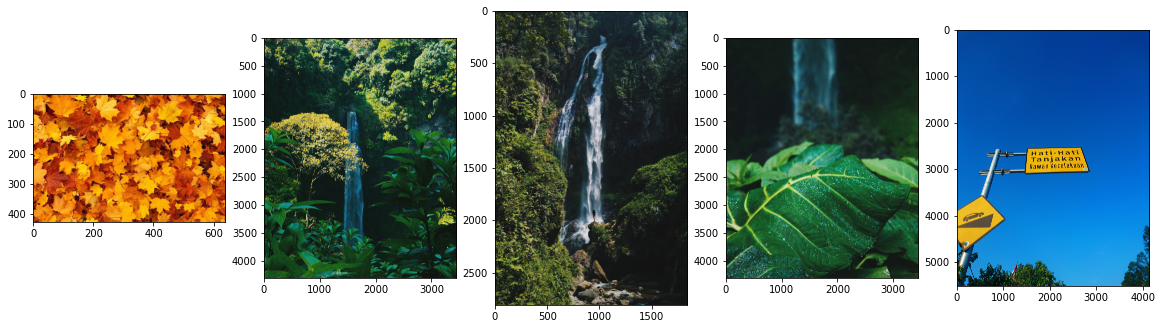

In [96]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

We define the function below. We will try to match with the top 10 colors of the image. It is highly possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image.

We keep a threshold value such that if the difference between the chosen color and any of the selected colors is less than that threshold, we declare it as a match.

Hex values or RGB values cannot be directly compared so we first convert them to a device independant and color uniform space. We use rgb2lab to convert the values and then find the difference using deltaE_cie76. The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image.


In [97]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

method for all the images in our set and show relevant images out of the same that approximately match our selected color.

In [98]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

Results


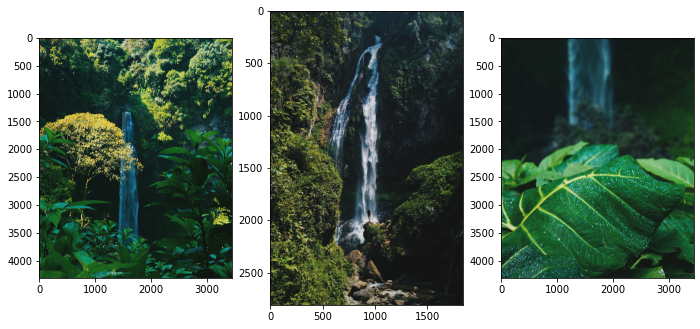

In [99]:
# Search for GREEN
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['GREEN'], 60, 6)

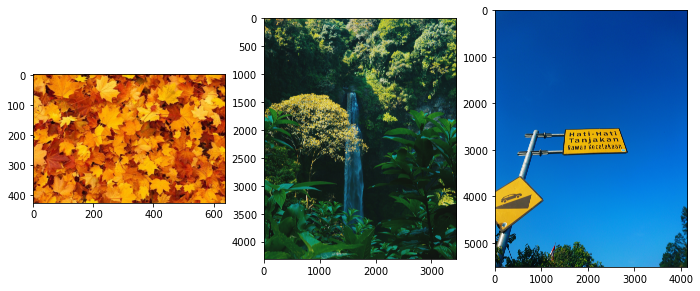

In [100]:
# Search for YELLOW
plt.figure(figsize = (20, 10))

show_selected_images(images, COLORS['YELLOW'], 60, 6)